In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plm_subnetworks.dataset.cath_dataset import get_cath_db
from plm_subnetworks.dataset import data_io
from plm_subnetworks.dataset.constants import SUBNETWORK_LEVELS_FOR_PLOTTING, PRETTY_NAMES

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from plm_subnetworks.dataset.data_paths import ESM_PPL_METRICS
RUN_DIR_PREFIX = "../results/subnetworks" # Change this to runs/ if evaluating new trained subnetworks

In [2]:
db = get_cath_db()

In [3]:
SEQ_SUPPRESSION_METADATA_PATH = "../results/metadata.csv"
SEQ_SUPPRESSION_METADATA_DF = pd.read_csv(SEQ_SUPPRESSION_METADATA_PATH) 

ESM_GT_DF = pd.read_csv(ESM_PPL_METRICS)

In [4]:
categories = [
    "residue",
    "cath_class_code",
    "cath_architecture_code",
    "cath_topology_code",
    "cath_homologous_superfamily_code",
    "random_seq",   
]

### Figure 2B

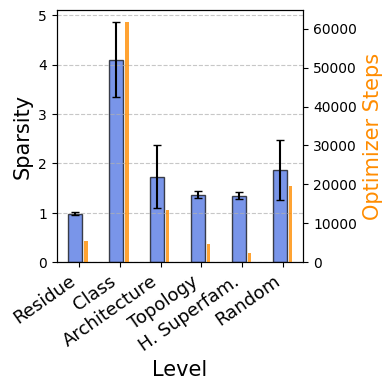

In [5]:
# Group by level and compute mean/std for sparsity
grouped_sparsity = SEQ_SUPPRESSION_METADATA_DF.groupby("category")["sparsity"]
mean_sparsity = grouped_sparsity.mean().reindex(categories)
std_sparsity = grouped_sparsity.std().reindex(categories)

# Group for optimizer_steps
grouped_steps = SEQ_SUPPRESSION_METADATA_DF.groupby("category")["steps"]
mean_steps = grouped_steps.mean().reindex(categories) * 4 # accumulate_grad_batch was set to 4 during all training

x = np.arange(len(categories))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(4, 4), dpi=100)

# Left y-axis: sparsity bars
bars1 = ax1.bar(
    x - bar_width / 4,
    mean_sparsity.values,
    width=bar_width,
    yerr=std_sparsity.values,
    capsize=3,
    color="royalblue",
    edgecolor="black",
    alpha=0.7,
    label="Sparsity"
)
ax1.set_ylabel("Sparsity", fontsize=15)
ax1.set_xlabel("Level", fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(
    [SUBNETWORK_LEVELS_FOR_PLOTTING[level] for level in categories],
    rotation=35,
    fontsize=13,
    ha="right"
)
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Right y-axis: optimizer steps as thin bars
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width / 2,
    mean_steps.values,
    width=bar_width / 4,
    color="darkorange",
    alpha=0.8,
    label="Optimizer Steps"
)
ax2.set_ylabel("Optimizer Steps", fontsize=15, color='darkorange')
ax2.tick_params(axis='y', labelcolor='black')

plt.tight_layout()
plt.show()

### Figure 2C

In [6]:
SMALL = 10
MEDIUM = 17
LARGE = 25

In [7]:
def get_random_model_performance(df, dir):
    run_dir = f"{RUN_DIR_PREFIX}/{dir}"
        
    suppressed_id_path = f"{run_dir}/random_supp_ids.txt"
    with open(suppressed_id_path, "r") as f:
        suppressed_ids = f.read().splitlines()
    print("Loaded suppressed ids:", len(suppressed_ids))
    
    supp_df = df[df["cath_id"].isin(suppressed_ids)]
    maint_df = df[~df["cath_id"].isin(suppressed_ids)]
    
    suppression_gt = ESM_GT_DF[ESM_GT_DF["cath_id"].isin(suppressed_ids)]
    maintenance_gt = ESM_GT_DF[~ESM_GT_DF["cath_id"].isin(suppressed_ids)]

    return supp_df, maint_df, suppression_gt, maintenance_gt

    

##### Note that the below block takes ~40 min to run

In [8]:
df_list_all = []
names_all = []
targets_all = []
types_all = []
sizes_all = []
catnames_all = []

for CATEGORY in categories:
    subset = SEQ_SUPPRESSION_METADATA_DF[SEQ_SUPPRESSION_METADATA_DF["category"] == CATEGORY]
    models = list(zip(subset["run_name"], subset["epoch"], subset["target"], subset["type"], subset["size"]))
    
    for DIR, EPOCH, TARGET, TYPE, SIZE in models:

        print(DIR)
        
        names_all.append(DIR)
        targets_all.append(TARGET)
        types_all.append(TYPE)
        sizes_all.append(SIZE)
        catnames_all.append(CATEGORY)

        BASE_DIR = f"{RUN_DIR_PREFIX}/{DIR}"
        
        SUBNETWORK_PPL = f"{BASE_DIR}/perplexity.csv"
        SUBNETWORK_DF=pd.read_csv(SUBNETWORK_PPL)
        SUBNETWORK_DF = data_io.hydrate_df_with_cath_terms(SUBNETWORK_DF, db)
      
        ESM_DF = data_io.hydrate_df_with_cath_terms(ESM_GT_DF, db)

        paired_dfs = (SUBNETWORK_DF, ESM_DF)
        df_list_all.append(paired_dfs)

residue_1
residue_2
class_1
class_2
arch_1.10
arch_1.25
arch_1.20
arch_2.30
arch_2.40
arch_2.60
arch_3.30
arch_3.40
arch_3.90
topo_1.10.10
topo_1.10.287
topo_1.20.58
topo_1.20.120
topo_1.25.40
topo_2.40.50
topo_2.60.40
topo_2.60.120
topo_3.30.70
topo_3.40.50
hsuperfam_3.40.50.300
hsuperfam_2.60.40.10
hsuperfam_3.40.50.720
hsuperfam_1.10.10.10
hsuperfam_3.20.20.80
hsuperfam_3.40.190.10
hsuperfam_3.40.50.150
hsuperfam_3.40.50.1820
hsuperfam_2.40.50.140
hsuperfam_3.40.30.10
random_seq_2000
random_seq_1000
random_seq_200
random_seq_100


In [11]:
def plot_ppl_model_vs_esm(
    dataframes, labels, targets, types, sizes, catnames,
    dpi=100, fontsize=20, savepath=None, colors=None
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    COLOR_MAP = {
        "alpha": colors[0],
        "beta": colors[1],
        "mixed": colors[2],
    }
    model_order = ["Subnet. (Supp.)", "Subnet. (Maint.)", "ESM-2 (Supp.)", "ESM-2 (Maint.)"]
    records = []

    # --- Aggregate metrics per run
    for (df_sub, df_esm), label, target, type_, size, catname in zip(dataframes, labels, targets, types, sizes, catnames):
        
        common_ids = set(df_sub["cath_id"]) & set(df_esm["cath_id"])
        df_sub = df_sub[df_sub["cath_id"].isin(common_ids)]
        df_esm = df_esm[df_esm["cath_id"].isin(common_ids)]

        marker_size = 8 if size < 100 else 12 if size <= 1000 else 16

        if catname == "residue":
            # Set suppression/maintenance targets
            if target=="1":
                supp_cat, maint_cat = "helix_mlm", ["strand_mlm", "coil_mlm"]
                marker_size = 16
            elif target=="2":
                supp_cat, maint_cat = "strand_mlm", ["helix_mlm", "coil_mlm"]
                marker_size = 12


            metrics = {
                "Subnet. (Supp.)": (np.exp(df_sub[supp_cat].mean()), np.exp(df_sub[supp_cat].std())),
                "Subnet. (Maint.)": (np.exp(df_sub[maint_cat].mean().mean()), np.exp(df_sub[maint_cat].std().mean())),
                "ESM-2 (Supp.)": (np.exp(df_esm[supp_cat].mean()), np.exp(df_esm[supp_cat].std())),
                "ESM-2 (Maint.)": (np.exp(df_esm[maint_cat].mean().mean()), np.exp(df_esm[maint_cat].std().mean())),
            }

            for model, (val, std) in metrics.items():
                records.append({
                    "Type": type_.strip().lower(),
                    "Category": catname,
                    "target": target,
                    "Metric": "perplexity",
                    "Model": model,
                    "Value": val,
                    "Std": std,
                    "Size": marker_size,
                    "#seqs": size,
                })

        else:
            if catname == "random_seq":
                sub_supp, sub_maint, esm_supp, esm_maint = get_random_model_performance(df_sub, label)
            else:
                sub_supp = df_sub[df_sub[catname] == target]
                sub_maint = df_sub[df_sub[catname] != target]
                esm_supp = df_esm[df_esm[catname] == target]
                esm_maint = df_esm[df_esm[catname] != target]

            for model, subset in zip(model_order, [sub_supp, sub_maint, esm_supp, esm_maint]):
                records.append({
                    "Type": type_.strip().lower(),
                    "Category": catname,
                    "target": target,
                    "Metric": "perplexity",
                    "Model": model,
                    "Value": subset["perplexity"].mean(),
                    "Std": subset["perplexity"].std(),
                    "Size": marker_size,
                    "#seqs": size,
                })

    df = pd.DataFrame(records)
    categories = list(dict.fromkeys(catnames))  # preserve order

    # --- Plotting
    fig, axs = plt.subplots(1, len(categories), figsize=(4 * len(categories), 6), dpi=dpi)

    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for ax, category in zip(axs, categories):
        cat_df = df[df["Category"] == category]

        sns.scatterplot(
            data=cat_df,
            x="Model",
            y="Value",
            hue="Type",
            palette=COLOR_MAP,
            size="Size",
            sizes={8: 150, 12: 400, 16: 750},
            ax=ax,
            alpha=0.6,
            edgecolor="black",
            linewidth=1,
            legend=False,
            zorder=2,
        )

        for i, model in enumerate(model_order):
            model_vals = cat_df[cat_df["Model"] == model]["Value"]
            if not model_vals.empty:
                median_val = model_vals.median()
                ax.hlines(median_val, i - 0.2, i + 0.2, colors="red", linewidth=2, zorder=3)

        ax.set_title(SUBNETWORK_LEVELS_FOR_PLOTTING.get(category, category), fontsize=fontsize + 4)
        ax.set_ylabel("", fontsize=fontsize)
        ax.set_xlabel("", fontsize=fontsize)
        ax.tick_params(axis="x", labelsize=fontsize - 1, rotation=45)
        ax.tick_params(axis="y", labelsize=fontsize - 2)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_xticks(range(len(model_order)))
        ax.set_xticklabels(model_order)
        for label in ax.get_xticklabels():
            label.set_ha("right")

        # Optional: set fixed y-limits based on category
        print(category)
        if category == "cath_homologous_superfamily_code": # inspect values of inferences to determine y-limits
            ax.set_ylim(0, 75)
        else:
            ax.set_ylim(0, 45)

    # --- Legends
    fig.supylabel("Perplexity", fontsize=fontsize + 4)

    fig.legend(
        handles=[
            Patch(facecolor=color, edgecolor="black", label=label.capitalize())
            for label, color in COLOR_MAP.items()
        ],
        title="Suppression Category\nSecondary Structure",
        title_fontsize=fontsize,
        fontsize=fontsize - 2,
        loc="upper left",
        bbox_to_anchor=(0.95, 0.93),
        borderaxespad=0,
        ncol=1,
    )
    fig.legend(
        handles=[
            Line2D([0], [0], marker="o", color="gray", label="< 100", markersize=8, linestyle=""),
            Line2D([0], [0], marker="o", color="gray", label="100–1000", markersize=12, linestyle=""),
            Line2D([0], [0], marker="o", color="gray", label="> 1000", markersize=25, linestyle=""),
            Line2D([0], [0], color="red", linewidth=2, label="Median", linestyle="-"),
        ],
        title="# Suppression Inputs",
        title_fontsize=fontsize,
        fontsize=fontsize - 2,
        loc="upper left",
        bbox_to_anchor=(0.935, 0.52),
        borderaxespad=1,
    )

    fig.subplots_adjust(left=0.075, right=0.94, top=0.92, bottom=0.12, wspace=0.3)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

    return df


In [12]:
df_results = plot_ppl_model_vs_esm(
    dataframes=df_list_all,
    labels=names_all,
    targets=targets_all,
    types=types_all,
    sizes=sizes_all,
    catnames=catnames_all,
    colors=["orange", "royalblue", "lightgray"],  # alpha, beta, mixed
    dpi=600,
    fontsize=21
)

Loaded suppressed ids: 2000
Loaded suppressed ids: 1000
Loaded suppressed ids: 200
Loaded suppressed ids: 100
residue
cath_class_code
cath_architecture_code
cath_topology_code
cath_homologous_superfamily_code
random_seq
